# Geospatial file format Performance Evaluation

This notebook contains: 
- An Overview of the GeoParquet standard
- Benchmark code for evaluating the GeoParquet file format using the following datasets:
    - The [Google-Microsoft combined Open Buildings](https://beta.source.coop/vida/google-microsoft-open-buildings/) for 2D building footprint data
    - The [Overture buildings dataset](https://medium.com/mapular/overture-maps-a-fusion-of-open-and-commercial-data-for-a-new-era-in-mapping-f26b4b56ad9a) for 2.5D building data
        - Explore the impact of Overture's 
- A discussion of the current state of cloud-optimized geospatial file formats generally and the potential of GeoParquet specifically

# Introduction

 GeoParquet is [an incubating Open Geospatial Consortium (OGC) standard](https://geoparquet.org/) that simply adds compatible geospatial [geometry types](https://docs.safe.com/fme/html/FME-Form-Documentation/FME-ReadersWriters/geoparquet/Geometry-Support.htm) (MultiPoint, Line, Polygon, etc) to the mature and widely adopted Apache Parquet format, a popular columnar storage format commonly used in big data processing. Parquet is a mature file format and has a wide ecosystem that GeoParquet seamlessly integrates with. This is analogous to how the GeoTIFF raster format adds geospatial metadata to the TIFF standard. GeoParquet is designed to be a simple and efficient way to store geospatial *vector* data in a columnar format, and is designed to be compatible with existing Parquet tools and libraries to enable Cloud _Data Warehouse_ Interopability. 

A Parquet file is made up of a a set of file chunks called "row groups". Row groups are logical groups of columns with the same number of rows. Each of these columns is actually a "column chunk" which is a contiguous block of data for that column. The schema across row groups must be consistent, ie the data types and number of columns must be the same for every row group. The new geospatial standard adds some relevant additional metadata such as the geometry's Coordinate Reference System (CRS), additional metadata for geometry columns, and future realeses will enable support for spatial indexing. [Spatial indexing](https://towardsdatascience.com/geospatial-data-engineering-spatial-indexing-18200ef9160b) is a technique used to optimize spatial queries by indexing or partitioning the data based on its geometry features such that you can make spatial queries (e.g. intersection, within, within x distance, etc) more efficiently. 

<figure>
<img src="https://miro.medium.com/v2/resize:fit:1400/1*QEQJjtnDb3JQ2xqhzARZZw.png" style="width:100%">
<figcaption align = "center"> Visualization of the layout of a Parquet file </figcaption>
</figure>

Beyond the file data itself, Parquet also stores metadata at the end of the file that describes the internal "chunking" of the file, byte ranges of every column chunks, several column statistics, among other things. 

<figure>
<img src="https://guide.cloudnativegeo.org/images/geoparquet_layout.png" style="width:100%">
<figcaption align = "center"> GeoParquet has the same laylout with additional metadata </figcaption>
</figure>

 

## Features and Advantages

- Efficient storage and compression: 
    - leverages the columnar data format which is more efficient for filtering on columns
    - GeoParquet is internally compressed by default, and can be configured to optimize decompression time or storage size depending on the use case
    - These make it ideal for applications dealing with _massive_ geospatial datasets and cloud data warehouses
- Scalability and High-Performance:
    - the nature of the file format is well-suited for parallel and/or distributed processing such as in Spark, Dask, or Hadoop
    - Support for data partitioning: 
        - Parquet files can be partitioned by one or more columns
        - In the geospatial context this enables efficient spatial queries and filtering (e.g. partitioning by ISO country code) 
- Optimized for *read-heavy workflows*: 
    - Parquet is an immutable file format, which means taking advantage of cheap reads, and efficient filtering and aggregation operations
        - This is ideal for data warehousing and modern analytic workflows 
        - Best paired with Analytical Databases like Amazon Redshift, Google BigQuery, or DuckDB
        - Ideal for OLAP (Online Analytical Processing) and BI (Business Intelligence) workloads that leverage historical and aggregated data that don't require frequent updates
 - Interoperability and wide ecosystem:
    - GeoParquet is designed to be compatible with existing Parquet readers, tools, and libraries
    - Facilitates integration into existing data pipelines and workflows
    - Broad compatibility:
        - support for multiple spatial reference systems 
        - support for multiple geometry types and multiple geometry columns
        - works with both planar and spherical coordinates 
        - support for 2D and 3D geometries
        
## Limitations and Disadvantages

- Poorly suited for write-heavy workflows:
    - Transactional and CRUD (Create, Read, Update, Delete) operations are not well-suited for Parquet files
    - Not recommended for applications that require frequent updates or real-time data ingestion
- Not a Silver Bullet for all geospatial data:
    - deals only with vector data, not raster data
    - storage and compression benefits require a certain scale of data to be realized
    - performance overhead for small datasets
- Limited support for spatial indexing:
    - GeoParquet did not implement spatial indexing in the 1.0.0 release
    - This is planned for future release in 

# Benchmark Results

In [1]:
from dotenv import load_dotenv
import os
import platform

# Constants and local env configuration
load_dotenv() # take environment variables from .env 

# use filepath loaded from env   
open_buildings_path = os.getenv("DATA_DIR") 
# make sure to parse as raw string to avoid issues with Windows paths
open_buildings_path = r"{}".format(open_buildings_path)
os.makedirs(os.path.join(open_buildings_path, "parquet"), exist_ok=True)
print("Open buildings data will be saved to: ", os.path.join(open_buildings_path, "parquet"))

# create env vars dict for use in multiprocessing benchmark scripts
env_vars = {
    "CONDA_PREFIX": os.getenv("CONDA_PREFIX"),
    "GDAL_DRIVER_PATH": os.getenv("GDAL_DRIVER_PATH"),
    # add both of these to the PATH so that the GDAL binaries can be found
    "PATH": os.getenv("PATH") + os.pathsep + os.getenv("CONDA_PREFIX") + os.pathsep + os.getenv("GDAL_DRIVER_PATH")
    
}

print("Conda prefix: ", env_vars["CONDA_PREFIX"])
print("GDAL driver path: ", env_vars["GDAL_DRIVER_PATH"])

# list of ISO country codes to fetch 
# buildings_countries = ["CUB","CHN", "AUS", "DEU" "USA"]
buildings_countries = ["BRB", "CAF", "JAM", "CUB", "GTM", "AUS"]
# buildings_countries = ["BRB"]
file_fmts = ["geojson", "shapefile", "flatgeobuf", "geopackage"]
compression_types = ["snappy", "gzip", "brotli", None]

Open buildings data will be saved to:  /Volumes/NAS_Base/nas_data/geospatial/google-ms-open-buildings/parquet
Conda prefix:  /Volumes/Expanse/mambaforge/envs/geospatial
GDAL driver path:  /Volumes/Expanse/mambaforge/envs/geospatial/lib/gdalplugins


### Filesystem performance tests

In [2]:
# import utilities for fetching and processing data, and benchmarking functions
from benchmark import *

In [3]:
# run full benchmarking pipeline
convert_df, compress_df = full_benchmark(country_list=buildings_countries,
                                                        file_formats=file_fmts,
                                                        compression_types=compression_types,
                                                        data_dir=open_buildings_path,
                                                        delete_output=True,
                                                        test_load=True, 
                                                        env_vars=env_vars,
                                                        multi_proc=True,
                                                        save_results=True)

BRB.parquet found at /Volumes/NAS_Base/nas_data/geospatial/google-ms-open-buildings/parquet/BRB.parquet
Testing load time for BRB.parquet
Successfully loaded BRB.parquet into geopandas dataframe
Starting conversion from parquet to geojson
Successfully converted BRB.parquet to BRB.geojson in 3.82s
Converted file size: 100.30 MB
Testing load time for BRB.geojson
Successfully loaded BRB.parquet into geopandas dataframe
Successfully converted BRB gdf to BRB.geojson in 18.76s
geojson file size: 100.30 MB
file sizes for geojson - ogr/gdal:100.30 MB, geopandas:100.30 MB
Starting conversion from parquet to shapefile
Successfully converted BRB.parquet to BRB.shp in 1.27s
Converted file size: 34.03 MB
Testing load time for BRB.shp
Successfully loaded BRB.parquet into geopandas dataframe


/Volumes/Expanse/repos/wovenwork/benchwork/ds_benchwork/benchmark.py:156: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  input_df.to_file(output_file, driver=FMT_GDAL_DRIVERS[output_format])


Successfully converted BRB gdf to BRB.shp in 16.49s
shapefile file size: 34.03 MB
file sizes for shapefile - ogr/gdal:34.03 MB, geopandas:34.03 MB
Starting conversion from parquet to flatgeobuf
Successfully converted BRB.parquet to BRB.fgb in 0.86s
Converted file size: 56.87 MB
Testing load time for BRB.fgb
Successfully loaded BRB.parquet into geopandas dataframe
Successfully converted BRB gdf to BRB.fgb in 16.17s
flatgeobuf file size: 56.87 MB
file sizes for flatgeobuf - ogr/gdal:56.87 MB, geopandas:56.87 MB
Starting conversion from parquet to geopackage
Successfully converted BRB.parquet to BRB.gpkg in 1.02s
Converted file size: 56.48 MB
Testing load time for BRB.gpkg
Successfully loaded BRB.parquet into geopandas dataframe
Successfully converted BRB gdf to BRB.gpkg in 26.75s
geopackage file size: 55.50 MB
file sizes for geopackage - ogr/gdal:56.48 MB, geopandas:55.50 MB
BRB.parquet found at /Volumes/NAS_Base/nas_data/geospatial/google-ms-open-buildings/parquet/BRB.parquet
Successful

In [5]:
convert_df

,country_code,output_format,processing_time,file_size,load_time
0,BRB,parquet,"[0.0, 0.0]",17.839197,0.273259
1,BRB,geojson,"[3.8217790126800537, 18.756132125854492]",100.300326,17.303624
2,BRB,shapefile,"[1.2699429988861084, 16.48810911178589]",34.027241,13.713605
3,BRB,flatgeobuf,"[0.8581361770629883, 16.17321491241455]",56.874390,13.467678
4,BRB,geopackage,"[1.0244767665863037, 26.75497817993164]",56.476562,13.629610


In [6]:
compress_df

,country_code,compression_type,compression_time,compression_size,load_time,geom_count
0,BRB,snappy,0.302624,20.471449,0.221945,243271
1,BRB,gzip,1.222633,15.824190,0.264194,243271
2,BRB,brotli,1.949642,14.441882,0.258168,243271
3,BRB,None,0.294209,27.163264,0.182121,243271


In [23]:
# in output format column, change "parquet" to "geoparquet"
convert_df["output_format"] = convert_df["output_format"].apply(lambda x: "geoparquet" if x == "parquet" else x)
# add geom_count column to convert_stats_df by joining on country_code
convert_df = convert_df.merge(compress_df[["country_code", "geom_count"]], on="country_code")
# display updated convert_stats_df  
convert_df

,country_code,output_format,processing_time,file_size,load_time,geom_count_x,geom_count_y,geom_count
0,BRB,geoparquet,"[0.0, 0.0]",17.839197,0.273259,243271,243271,243271
1,BRB,geoparquet,"[0.0, 0.0]",17.839197,0.273259,243271,243271,243271
2,BRB,geoparquet,"[0.0, 0.0]",17.839197,0.273259,243271,243271,243271
3,BRB,geoparquet,"[0.0, 0.0]",17.839197,0.273259,243271,243271,243271
4,BRB,geoparquet,"[0.0, 0.0]",17.839197,0.273259,243271,243271,243271
...,...,...,...,...,...,...,...,...
315,BRB,geopackage,"[1.0244767665863037, 26.75497817993164]",56.476562,13.629610,243271,243271,243271
316,BRB,geopackage,"[1.0244767665863037, 26.75497817993164]",56.476562,13.629610,243271,243271,243271
317,BRB,geopackage,"[1.0244767665863037, 26.75497817993164]",56.476562,13.629610,243271,243271,243271
318,BRB,geopackage,"[1.0244767665863037, 26.75497817993164]",56.476562,13.629610,243271,243271,243271


In [24]:
convert_df.name = "Conversion Stats"
# save to csv with country_codes in filename
country_codes = "_".join(convert_df["country_code"].unique())
convert_df.to_csv(f"{open_buildings_path}/benchmark_{country_codes}_conversion.csv", index=False)
pretty_print_df_info(convert_df)

Dataframe info for Conversion Stats:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country_code     320 non-null    object 
 1   output_format    320 non-null    object 
 2   processing_time  320 non-null    object 
 3   file_size        320 non-null    float64
 4   load_time        320 non-null    float64
 5   geom_count_x     320 non-null    int64  
 6   geom_count_y     320 non-null    int64  
 7   geom_count       320 non-null    int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 20.1+ KB
None
  country_code output_format processing_time  file_size  load_time  \
0          BRB    geoparquet      [0.0, 0.0]  17.839197   0.273259   
1          BRB    geoparquet      [0.0, 0.0]  17.839197   0.273259   
2          BRB    geoparquet      [0.0, 0.0]  17.839197   0.273259   
3          BRB    geoparquet      [0.0, 0.0]  17.83

### Plotting performance results

In [25]:
# functions for plotting stats with seaborn

import seaborn as sns

def barplot(data, x, y, title, xlabel, ylabel, hue=None, orient='v', color=None, xticks=None, yticks=None, xticklabels=None, yticklabels=None):
    # create horizontal barplot
    ax = sns.barplot(data=data, x=x, y=y, hue=hue, orient=orient, color=color)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)    
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels)
    if yticklabels is not None:
        ax.set_yticklabels(yticklabels)

def scatter_plot(data, x, y, title, xlabel, ylabel, hue=None, xticks=None, yticks=None, xticklabels=None, yticklabels=None):
    # create scatter plot
    ax = sns.scatterplot(data=data, x=x, y=y, hue=hue)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if xticks is not None:
        ax.set_xticklabels(xticks)
    if yticks is not None:
        ax.set_yticklabels(yticks)
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels)
    if yticklabels is not None:
        ax.set_yticklabels(yticklabels)

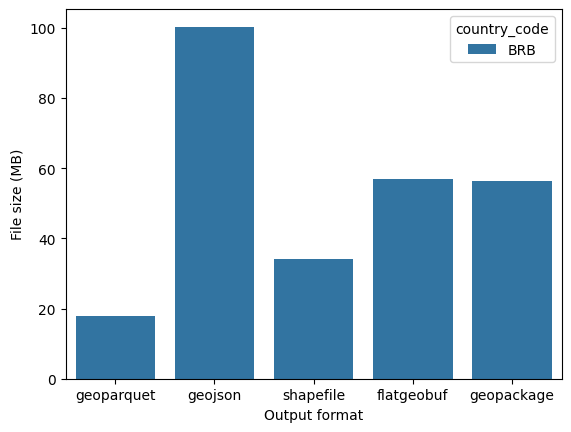

In [26]:
# create a grouped bar plot where y is file size and x is file format and file sizes are grouped by country code
barplot(data=convert_df, x="output_format", y="file_size", title="File size by output format", xlabel="Output format", ylabel="File size (MB)", hue="country_code")

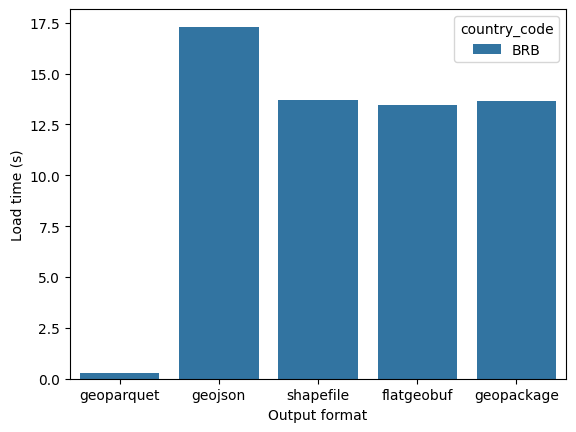

In [27]:
# create a grouped bar plot where y is load time and x is file format and load times are grouped by country code
barplot(data=convert_df, x="output_format", y="load_time", title="Load time by output format", xlabel="Output format", ylabel="Load time (s)", hue="country_code")

/var/folders/71/3fjqkxbs6w3frshvsfj30fmm0000gn/T/ipykernel_29854/3378228224.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)
/var/folders/71/3fjqkxbs6w3frshvsfj30fmm0000gn/T/ipykernel_29854/3378228224.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks)
/var/folders/71/3fjqkxbs6w3frshvsfj30fmm0000gn/T/ipykernel_29854/3378228224.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)
/var/folders/71/3fjqkxbs6w3frshvsfj30fmm0000gn/T/ipykernel_29854/3378228224.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklabels)


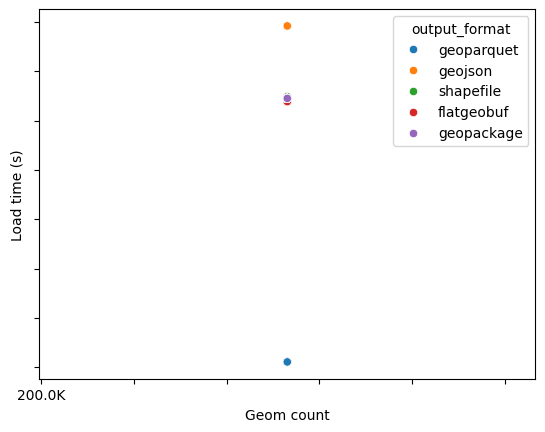

In [28]:
# modify xticks for geom_count to display 200K ticks up to max geom_count in dataset
xticks = [i for i in range(0, max(convert_df["geom_count"]), 200000)]
xticklabels = [f"{i/1000}K" for i in xticks]

print()
# modify yticks for load_time to display 30s ticks up to max load_time in dataset
yticks = [f"{i}s" for i in range(0, max(convert_df["load_time"].astype(int)), 30)]
yticklabels = [f"{i}s" for i in range(0, max(convert_df["load_time"].astype(int)), 30)]

# create a scatter plot where x is geom count and y is load time and points are colored by file format
scatter_plot(data=convert_df, x="geom_count", y="load_time", title="Load time by geom count", xlabel="Geom count", ylabel="Load time (s)", hue="output_format", xticks=xticks, yticks=yticks, xticklabels=xticklabels, yticklabels=yticklabels)

### Querying in-memory with GeoPandas 

Query brainstorming: 
- simple geometry/building count per country
    - visualization: interactive international map with countries shaded or scaled by building count
- distribution of square area of buildings per country or per other attribute
    - comparison of square area distributions between countries
        - how do we compare/match distributions? descriptive statistics? 
- 

### Querying from files with DuckDB

### Visualization with Basemaps

### 3D Data with Overture

# Discussion on cloud-native geospatial data formats

# References
- https://geoparquet.org/
- https://geopandas.org/
- https://radiant.earth/blog/2023/10/what-is-source-cooperative/
- https://guide.cloudnativegeo.org/geoparquet/
- https://medium.com/mapular/overture-maps-a-fusion-of-open-and-commercial-data-for-a-new-era-in-mapping-f26b4b56ad9a
- https://towardsdatascience.com/geospatial-data-engineering-spatial-indexing-18200ef9160b
- https://github.com/opengeospatial/geoparquet/blob/main/format-specs/geoparquet.md 
- https://medium.com/radiant-earth-insights/geoparquet-1-1-coming-soon-9b72c900fbf2